## Imports

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [ ]:
from create_models.inception_tuner import Classifier_INCEPTION

In [ ]:
# load utility
from utils.preprocess_data import load_armans_dataset, load_timeseries_dataset
from utils.preprocess_data import to_onehot, Standardize, Minmax, scale_x, adjust_dimensions
from utils.visualize import plot_loss_acc, plot_confusion_matrix, plot_lr, plot_lr_schedule
from utils.save import save_model_to_lite

In [ ]:
from datetime import datetime
import math
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
from os.path import join
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import tensorflow as tf
from keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard
import keras_tuner

import tensorflow_models as tfm
import tensorflow_addons as tfa

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
%config Completer.use_jedi = True

## Config - Change params here

In [ ]:
timestamp_begin = '19.10.22 00:00'

In [ ]:
# set True to only regard sitting, standing, walking, cycling as activites
common_only = True

In [ ]:
frequency = 5 # choose between 5 Hz and 15 Hz measurements
frame_seconds = 2 # how many seconds should one data point have? 5 Hz * 2 seconds = 10 data points per window frame

cut_sensors_bool = True
n_keep = 12 if cut_sensors_bool else None  # if < 8 and 'pca = TRUE'

In [ ]:
pca = True
n_components = 10

In [ ]:
scaler = None
# !!!!!!!!!!!!!!!!!!!!!!!! if scaled, the model cant be used on variable sensor length anymore which breaks it
# solution could be to get one mean and std over all sensor and then use these 2 values in the app + the mean,std for the acceleration
scaler = Standardize()
# scaler = Minmax() # garbage

In [ ]:
tune_model = True  # if True, keras_tuner searches for the best model, else the default values are used
max_trials = 1

In [ ]:
batch_size = 1048
epochs = 3
verbose = 0

In [ ]:
# retrain = True

In [ ]:
pre_plots = True

In [ ]:
# tb_logs = True  # if True, watch out for a ton of logs. 100 trials ~1-2 GB Data
tb_logs = False

## Load and preprocess data

In [ ]:
# x_train, y_train, x_val, y_val = load_armans_dataset(n_keep=n_keep, trimmed_act=True, verbose=False)
x_train, y_train, x_val, y_val = load_timeseries_dataset(frequency=frequency,
                                                         frame_seconds=frame_seconds,
                                                         n_keep=n_keep,
                                                         timestamp_begin=timestamp_begin,
                                                         common_only=common_only)

249 Files read in total (ignoring different frequencies)


In [ ]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((38204, 10, 30), (38204,), (38081, 10, 30), (38081,))

In [ ]:
# helper function to create heatmap labels
x_cols = [*(map(lambda x: f"l{x}"  , range(1,13))), *(map(lambda x: f"r{x}"  , range(1,13))), 
          "x", "y", "z", 'gyr_x', 'gyr_y', 'gyr_z']

In [ ]:
x_train_df = pd.DataFrame(x_train.reshape(x_train.shape[0] * x_train.shape[1], x_train.shape[2]), columns=x_cols)
# x_train_df

In [ ]:
# if pre_plots:
#     f,ax = plt.subplots(figsize=(18, 18))
#     sns.heatmap(x_train_df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax);

# takeaways
#  sensors left 1-12 correlate with sensors right 1-12 (0.7 - 0.8)
# sensors right next to each other (0.4 - 0.9)
# some sensor have negative correlation r5 - l7; r9 - l11; l8 - r5
# -> might be because of the flexion of the back (s-form) in the middle

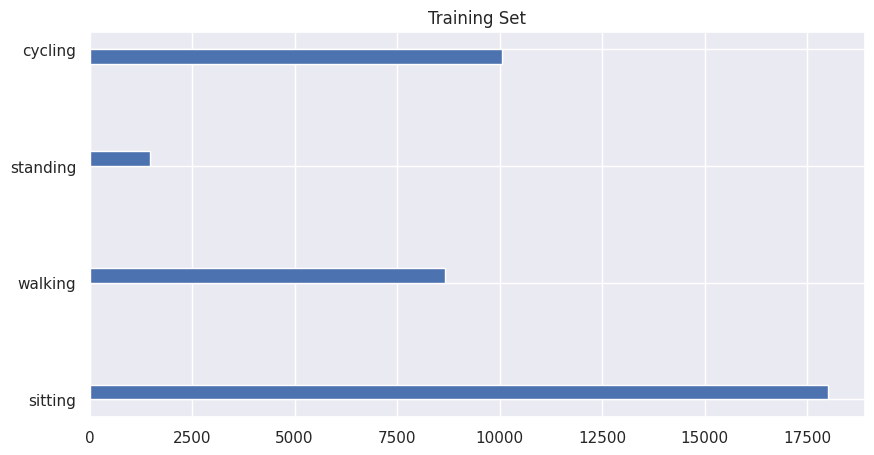

In [ ]:
if pre_plots:
    plt.figure(figsize=(10,5))
    plt.hist(y_train, orientation="horizontal", bins="scott")
    plt.title("Training Set");

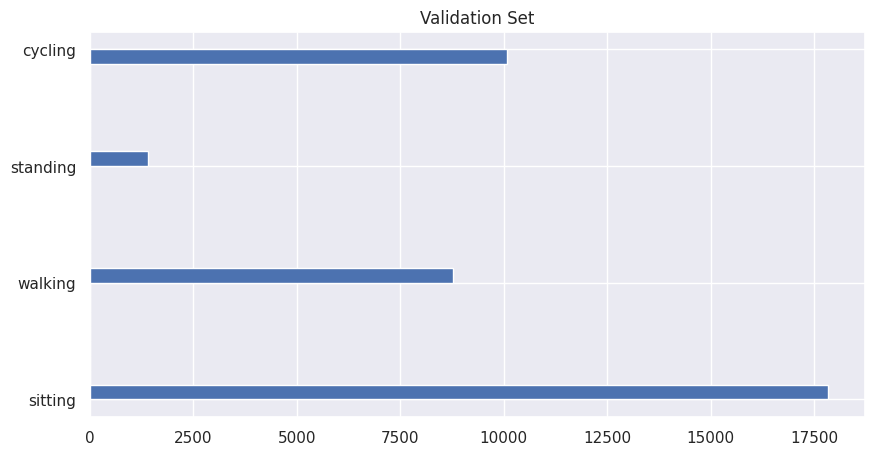

In [ ]:
if pre_plots:
    plt.figure(figsize=(10,5))
    plt.hist(y_val, orientation="horizontal", bins="scott")
    plt.title("Validation Set");

In [ ]:
lbl_enc = LabelEncoder()
y_enc = lbl_enc.fit_transform(np.concatenate((y_train, y_val)))
y_train = y_enc[:len(y_train)]
y_val = y_enc[len(y_train):]

y_train = to_onehot(y_train)
y_val = to_onehot(y_val)

In [ ]:
y_train.shape

(38204, 4)

In [ ]:
y_val.shape

(38081, 4)

In [ ]:
if scaler:
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)
    print(f"---\nscaled with {scaler.__class__.__name__}!\n---")

---
scaled with Standardize!
---


In [ ]:
if pca:
    # assert (n_keep * 2 >= n_components) if cut_sensors_bool else True, f"Increase n_keep={n_keep} to atleast greater than half the size of n_components={n_components}"
    print("---\nDoing PCA!\n---")
    x_train, x_val, pca_components = adjust_dimensions(x_train, x_val, n_components, return_components=True)
    print("After PCA x shape:", x_train.shape[1:])
else:
    pca_components = None
    print("NO PCA DONE!")

---
Doing PCA!
---
[0.75217983 0.04661026 0.0445406  0.03838658 0.03276576 0.03060769
 0.02952833 0.02162383 0.0017769  0.00086392]
After PCA x shape: (10, 10)


In [ ]:
x_train.shape, x_val.shape

((38204, 10, 10), (38081, 10, 10))

In [ ]:
x_train.mean((0,1))

array([ 7.00797044e-15,  9.17731671e-16, -7.95203780e-16,  1.62953911e-15,
        1.57954595e-15,  3.39477396e-15, -1.21858340e-15, -4.06611075e-15,
        2.81092521e-15, -4.21225148e-14])

In [ ]:
x_val.mean((0,1))

array([-5.76441484e-03,  8.57548959e-03,  8.96497571e-03, -4.04033777e-03,
        1.63516211e-03,  3.24814268e-03,  1.84670212e-03,  1.96793107e-03,
       -1.53693986e-03,  5.85835265e-05])

In [ ]:
x_train.std((0,1))

array([4.75030472, 1.18250068, 1.15594895, 1.07312506, 0.99144989,
       0.95824361, 0.94119603, 0.80542844, 0.23088298, 0.16098946])

In [ ]:
x_val.std((0,1))

array([4.70898276, 1.20347451, 1.47095763, 1.08022238, 0.98798666,
       0.95377822, 0.94322895, 0.79902667, 0.16803537, 0.16123117])

## Creating Model

In [ ]:
cur_time = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
output_dir = join("results", f"inception_{cur_time}", "")

In [ ]:
cbs = []
if tb_logs:
    tb_cb = TensorBoard(join(output_dir, "tb_logs"), write_graph=False)
    cbs.append(tb_cb)

In [ ]:
inception = Classifier_INCEPTION(output_dir, x_train.shape[1:], y_train.shape[-1], callbacks=cbs, max_trials=max_trials,
                                 epochs=epochs, batch_size=batch_size, verbose=verbose, lbl_enc=lbl_enc)
# inception.model.summary()

## Training Model

In [ ]:
# inception.fit(x_train, y_train, x_val, y_val)

In [ ]:
if tune_model:
    inception.tune_hp(x_train, y_train, x_val, y_val)
else:
    inception.build_default()

Trial 1 Complete [00h 01m 11s]
val_f1_score: 0.7775852680206299

Best val_f1_score So Far: 0.7775852680206299
Total elapsed time: 00h 01m 11s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


{'depth': 6, 'dropout_1': 0.25, 'dropout_2': 0.5, 'dropout_dense': 0.25, 'learning_rate': 0.00039405845335838835, 'weight_decay': 4.684170745385077e-07}


INFO:tensorflow:Assets written to: results/inception_2022-12-08_14:43:50/best_model/assets


INFO:tensorflow:Assets written to: results/inception_2022-12-08_14:43:50/best_model/assets


,accuracy,f1_score,precision,recall,duration
0,0.89026,0.777585,0.826337,0.756431,71


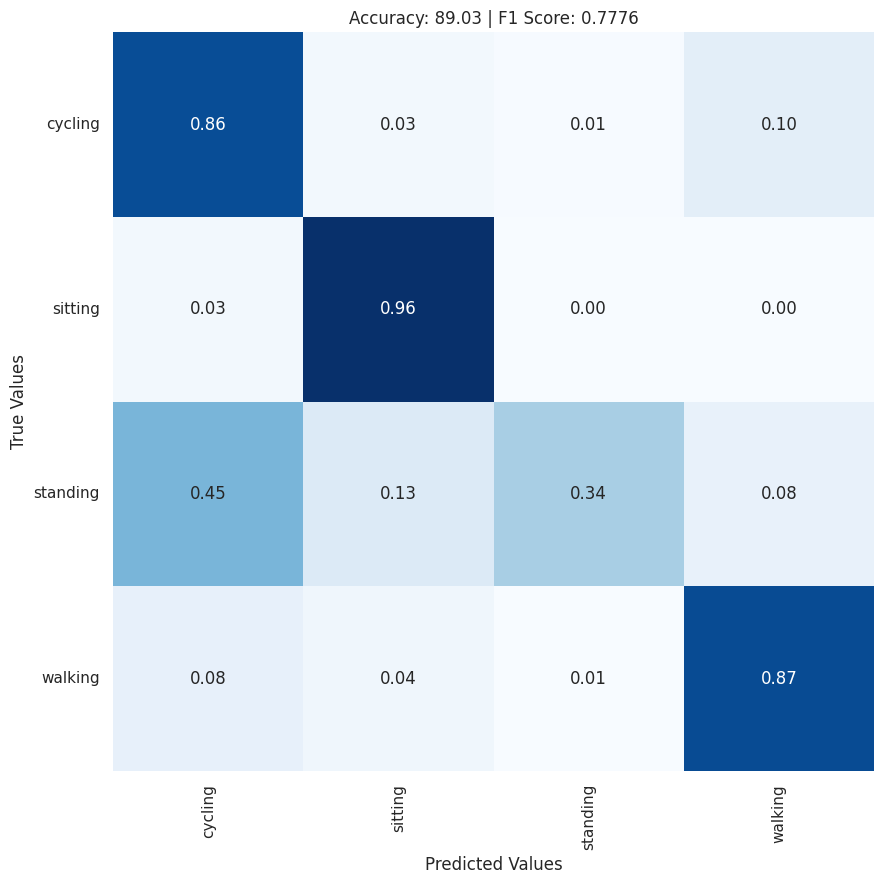

In [ ]:
df_metrics = inception.predict(x_val, y_val)
df_metrics

In [ ]:
# rerun training
# if retrain & tune_model:
#     inception.model = inception.build(inception.best_hps[0])
#     df_metrics = inception.fit(x_train, y_train, x_val, y_val)
#     print(df_metrics)

In [ ]:
save_model_to_lite(join(output_dir, "best_model"), x_train.shape, y_train.shape, lbl_enc.classes_, n_keep, pca_components, scaler)

Model + utilities successfully saved!


In [ ]:
model_demo = load_model(join(output_dir, "best_model"), custom_objects={"f1_loss": inception.model.loss})
# model_demo.summary()

In [ ]:
# saves model optimizer config
# opt_df = pd.DataFrame.from_dict(model_demo.optimizer.get_config(), orient="index").T
# opt_df.to_csv(join(output_dir, "optimizer.csv"))
# opt_df

## Plot predictions probabilities

In [ ]:
# y_pred = tf.keras.activations.sigmoid(model_demo.predict(x_val, verbose=0))
y_pred = model_demo.predict(x_val, verbose=0)

In [ ]:
pred_n = y_pred.shape[-1]

In [ ]:
tresh = 0.7

In [ ]:
idx = 1000

In [ ]:
y_pred_sorted_acts = [lbl_enc.classes_[k] for k in np.argsort(y_pred[idx])]

In [ ]:
true_act = lbl_enc.classes_[np.argmax(y_val[idx])]
true_act

'walking'

In [ ]:
for i,act in enumerate(y_pred_sorted_acts):
    if act == true_act:
        true_idx = i

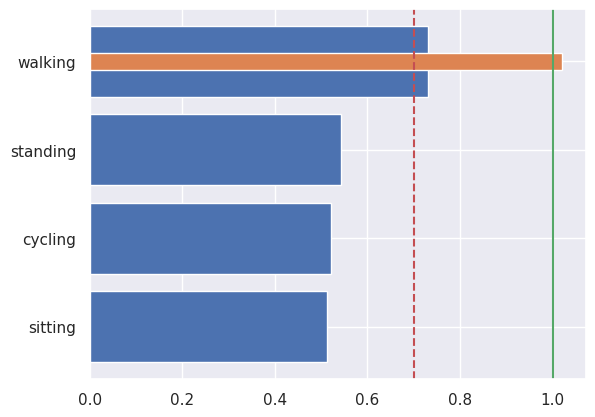

In [ ]:
fig,ax = plt.subplots()
plt.barh(range(pred_n), sorted(y_pred[idx]))
plt.barh(true_idx, 1.02, 0.2)
plt.axvline(tresh, color="r", linestyle="--")
plt.axvline(1, color="g")
ax.set_yticks(range(pred_n), y_pred_sorted_acts);

In [ ]:
plot_model(model_demo, join(output_dir, "model.png"), dpi=300, show_shapes=True, expand_nested=True)
plt.close()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [ ]:
if tb_logs:
    tb_dir = join(output_dir, "tb_logs")
    %tensorboard --logdir $tb_dir

In [ ]:
# assert 1 == 0

does the model work well on new data?
1 or 2 very high predictions (1: laying, 2: running)

In [ ]:
def cut_sensors(x, n_keep):
        """ONLY for Armans dataset (NO GYRO DATA)"""
        if n_keep is None:  # do nothing
            return x

        n_sensors = (x.shape[-1] - 3) // 2
        x_left = x[:, :, :n_keep]
        x_right = x[:, :, n_sensors:n_sensors + n_keep]
        x_acc = x[:, :, -3:]

        return np.concatenate((x_left, x_right, x_acc), axis=-1)

# Demo 

In [ ]:
assert 1 == 0

AssertionError: 

In [ ]:
# df_demo = pd.read_csv("1666173916383_Xiaomi_M2007J17G_FT26A_5Hz_walking_input-matrix-test.csv").iloc[:, :-5]  # no gyro, voltage and timestamp
df_demo = pd.read_csv("input/1666341685432_samsung_SM-A528B_FT26A_5Hz_other_demo.csv").iloc[:, :-5]  # no gyro, voltage and timestamp
df_demo

In [ ]:
x_demo = []
for i in range(0, df_demo.shape[0] - 10, 5):
    x_temp = df_demo.iloc[i : i + 10, :]
    x_demo.append(x_temp)
x_demo = np.array(x_demo)
x_demo.shape

In [ ]:
x_demo = cut_sensors(x_demo, n_keep)
x_demo.shape

In [ ]:
x_demo_strain = x_demo[:,:,:-3]
x_demo_acc = x_demo[:,:,-3:]
x_demo_strain.shape, x_demo_acc.shape

In [ ]:
pca_components.shape

In [ ]:
x_demo_strain_pca = x_demo_strain @ pca_components[None, :, :]
x_demo_strain_pca.shape

In [ ]:
x_demo_ready = np.concatenate((x_demo_strain_pca, x_demo_acc), axis=-1)
x_demo_ready.shape

In [ ]:
if scaler:
    x_demo_ready = scaler.transform(x_demo_ready)
    x_demo_ready.shape

In [ ]:
x_train.mean((0,1))

In [ ]:
x_train.std((0,1))

In [ ]:
x_val.mean((0,1))

In [ ]:
x_val.std((0,1))

In [ ]:
x_demo_ready.mean((0,1))

In [ ]:
x_demo_ready.std((0,1))

In [ ]:
model_preds = model_demo.predict(x_demo_ready)
model_preds[:10]

In [ ]:
np.argmax(model_preds, axis=-1)

In [ ]:
lbl_enc.inverse_transform(np.argmax(model_preds, axis=-1))